In [2]:
# Goal: hierarchical clustering of 70 topic model, topic clustering as TREE
# To do: move to plotly dash
# Resource: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

# Helper libraries
import pandas as pd
import numpy as np
import random
import spacy

# Dimensionality reduction (topic model, embedding)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

# Plotting tools
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [3]:
# DATA Load preprocessed documents (articles, projects) from csv; create text column 'combined' (title, abstract)
print("Loading documents")
df = pd.read_csv("data/ERI-combined-full-2009-2019.csv")
df['combined'] = df['title'].astype(str) + ' ' + df['abstract'].astype(str)
print(len(df))
df.head()

Loading documents
3770


,id,start_year,end_year,title,abstract,type,authors,identifier,combined
0,0a,2019,2019,"Proteomic, gene and metabolite characterizatio...",Cadmium sulfide quantum dots regulate nanomate...,article,"Majumdar, Sanghamitra; Pagano, Luca; Wohlschle...",10.1039/c9en00599d,"Proteomic, gene and metabolite characterizatio..."
1,1000a,2014,2014,Evaluation of Aquarius Level 2 Soil Moisture P...,Validation is important for any satellite-base...,article,"Li, Dongyang; Zhao, Tianjie; Shi, Jiancheng; B...",10.1109/igarss.2014.6946966,Evaluation of Aquarius Level 2 Soil Moisture P...
2,1001a,2014,2014,Fusion of Space-Based CO2 Products and its Com...,"Currently, ascertaining and quantifying the gl...",article,"Jing, Yingying; Shi, Jiancheng; Wang, Tianxing",10.1109/igarss.2014.6946946,Fusion of Space-Based CO2 Products and its Com...
3,1002a,2014,2014,Water Vapor Retrieval Over Cloud Cover Area on...,This study mainly discusses atmospheric water ...,article,"Ji, Dabin; Shi, Jiancheng",10.1109/jstars.2014.2298979,Water Vapor Retrieval Over Cloud Cover Area on...
4,1003a,2014,2014,Toward Accurate XCO2 Level 2 Measurements by C...,Carbon dioxide (CO2) is one of the most import...,article,"Jing, Yingying; Wang, Tianxing; Shi, Jiancheng",10.1109/eorsa.2014.6927857,Toward Accurate XCO2 Level 2 Measurements by C...


In [5]:
# NLP Remove stopwords, vectorize text with unigrams and bigrams, construct matrix of TFIDF features
np.random.seed(13) #set random seed for reproducbility
n_features = 1000 #optional - number of features ordered by term frequency to include in model
#n_topics = 9 #number of topics - coarse thematic granularity
n_topics = 36 #number of topics - coarse thematic granularity
#n_topics = 70 #number of topics- fine thematic granularity
n_top_words = 10 #number of keywords returned per topic

custom_stop_words = []
with open( "mallet-2.0.8/stoplists/en-custom.txt", "r" ) as fin:  #load custom stop word list
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
        
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words=custom_stop_words)
tfidf = tfidf_vectorizer.fit_transform(df['combined'])
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (tfidf.shape[0], tfidf.shape[1]) ) #terms by features

Created 3770 X 80046 TF-IDF-normalized document-term matrix


In [6]:
# TOPIC MODEL build embedding for topics, return topics and keywords
nmf = NMF(n_components=n_topics, init="nndsvd").fit(tfidf) # create the model

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
        
print("Topics found via NMF:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics found via NMF:

Topic #0:
wave waves seismic velocity rayleigh pressure surface structure wind noise


Topic #1:
deformation crustal ma pamir shear himalayan rocks exhumation tibetan himalaya


Topic #2:
snow swe snow cover cover snow water water equivalent snowmelt equivalent snowpack snow depth


Topic #3:
soil moisture moisture soil band smap surface roughness surface soil algorithm m3


Topic #4:
climate climate change change adaptation future impacts models responses global species


Topic #5:
species diversity richness plant native species richness biodiversity communities biomass abundance


Topic #6:
fault slip rupture earthquake faults motion earthquakes ground ground motion seismic


Topic #7:
mantle lavas isotopic crust 3he samoan 4he 3he 4he geochemical melt


Topic #8:
soil microbial soils plant biomass organic microbial biomass dry nitrogen soil microbial


Topic #9:
amazon floodplain forest river basin deforestation amazon floodplain inundation cover forests


Top

In [7]:
# TOPIC MODEL transform tfidf-matrix into nmf-embedding
nmf_embedding = nmf.transform(tfidf)
top_idx = np.argsort(nmf_embedding,axis=0)[-3:]

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(df.iloc[idx]['title'])  
        print(df.iloc[idx]['authors'])
    count += 1

print( "Created %d X %d document-topic matrix" % (nmf_embedding.shape[0], nmf_embedding.shape[1]) ) 


Topic 0:
An approach to improve Rayleigh-wave ellipticity estimates from seismic noise: application to the Los Angeles Basin
Tanimoto, Toshiro; Yano, Tomoko; Hakamata, Tomohiro
SCEC3 Participation: Using Seismic noise for the purpose of improving shallow S-wave velocity models
Toshiro Tanimoto
SCEC3: Using Seismic noise for the purpose of improving shallow S-wave velocity models
Toshiro Tanimoto; Ralph Archuleta

Topic 1:
Tectonic evolution of the middle crust in southern Tibet from structural and kinematic studies in the Lhagoi Kangri gneiss dome
Diedesch, Timothy F.; Jessup, Micah J.; Cottle, John M.; Zeng, Lingsen
Building the Pamir Tibetan PlateauCrustal stacking, extensional collapse, and lateral extrusion in the Central Pamir: 1. Geometry and kinematics
Rutte, Daniel; Ratschbacher, Lothar; Schneider, Susanne; St  bner, Konstanze; Stearns, Michael A.; Gulzar, Muhammad A.; Hacker, Bradley R.
Direct shear fabric dating constrains early Oligocene onset of the South Tibetan detachmen

In [8]:
# Reduce dimensionality
tsne = TSNE(perplexity=7, early_exaggeration=5, random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding.T)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
print( "Created %d X %d matrix" % (tsne_embedding.shape[0], tsne_embedding.shape[1]) ) 

Created 36 X 2 matrix


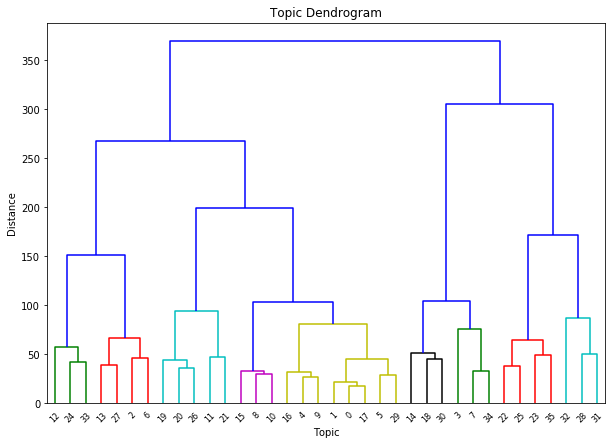

In [80]:
# Determine number of clusters for splitting data; minimize distance between topics based on term weights
plt.figure(figsize=(10, 7))
plt.title("Topic Dendrogram")
plt.xlabel("Topic")
plt.ylabel("Distance")
dend = dendrogram(shc.linkage(tsne_embedding, method='ward'),color_threshold=100)
#cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
#cluster.fit_predict(tsne_embedding)
#plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=cluster.labels_, cmap='rainbow')
plt.savefig("figures/NMF-t-SNE-36-topic-dendrogram-ward.png", dpi=300)